In [1]:
#Import libraries
import sys
sys.path.append('..')
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from utils.functions import plot_predictive
from utils.layers import BatchLinear
from utils.layers import AnchoredBatch



## Organize Toy Dataset

In [2]:
def features(x):
    return np.hstack([x[:, None] / 2.0, (x[:, None] / 2.0) ** 2])

In [3]:
# Load toy dataset
data = np.load(r"..\data\toy_data.npy")
#data = data[1:] # Remove an outlier
x, y = data[:, 0], data[:, 1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform x with two features -> 2 column tensor
f = features(x)

dataset = torch.utils.data.TensorDataset(torch.from_numpy(f.astype(np.float32)).to(device), 
                                         torch.from_numpy(y.astype(np.float32)).reshape(-1, 1).to(device))

In [4]:
BATCH_SIZE = 32


# Initialize the dataloaders
dataloader = DataLoader(dataset=dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False)


# Check what we've created
print(f"DataLoader: {dataloader}" )
print(f"Length of train_dataloader: {len(dataloader)} batches of {BATCH_SIZE}...")

# Input to the model is (samples/batch size) x batch size
print(f"#Training datasamples/Batch Size: {len(data)}/{BATCH_SIZE}= {len(data)/BATCH_SIZE}")

DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x00000235BC7DE050>
Length of train_dataloader: 13 batches of 32...
#Training datasamples/Batch Size: 400/32= 12.5


## Create a Base NN

In [47]:
class BaseNN(nn.Module):
        def __init__(self,
                     input_shape:int, 
                     hidden_units: int, 
                     output_shape: int):
            super().__init__()
            self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=1),
        )
        def forward(self, x):
            return self.layer_stack(x)

# Create first deep ensemble
Our first Deep Ensemble will act as a baseline model to compare with. It has a very "Naive" approach.  
We train each ensemble member for 10 epochs with a simple NN archtiecture (BaseNN), we do not inject any noise or prior belief into our model.

In [53]:
M = 5 # Number of ensemble members

# Initiate models
NaiveEnsemble = [BaseNN(input_shape=2,hidden_units=128,output_shape=1) for i in range(M)]

In [71]:
# Training Parameters
EPOCHS = 300
# Train each ensemble member
for model in NaiveEnsemble:
    # Initiate Loss function and Optimizer
    loss_function = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr= 0.02, weight_decay=0.)
    model.to(device)
    # Conduct training
    for epoch in range(EPOCHS):
        # Training
        train_loss = 0
        # Add a loop to loop through the training batches
        for batch, (X, y) in enumerate(dataloader):
            model.train()
            # 1. Perform forward pass
            y_pred = model(X) # Make prediction

            # 2. Calculate loss per batch
            loss = loss_function(y_pred.squeeze(), y) # Calculate loss with MSE

            train_loss += loss.item() # Accumalate loss

            # 3. Optimizer zero grad
            optimizer.zero_grad() # Set the optimizer's gradients to zero

            # 4. Loss backward
            loss.backward()

            #5. Optimizer step
            optimizer.step()
        if epoch%50 == 0:
            print(f"Epoch: {epoch}\n-------")
            print("Loss:", train_loss / (batch + 1))  # Calculate and print average loss per epoch
        
    

Epoch: 0
-------
Loss: 0.08365364243777898
Epoch: 50
-------
Loss: 0.0032902536555551565
Epoch: 100
-------
Loss: 0.0031672639306634665
Epoch: 150
-------
Loss: 0.003195570817647072
Epoch: 200
-------
Loss: 0.0031589339666355113
Epoch: 250
-------
Loss: 0.0031175611433214867
Epoch: 0
-------
Loss: 0.0718928685841652
Epoch: 50
-------
Loss: 0.003127665402224431
Epoch: 100
-------
Loss: 0.0030981105788109396
Epoch: 150
-------
Loss: 0.003057424176054505
Epoch: 200
-------
Loss: 0.0029931107464318094
Epoch: 250
-------
Loss: 0.002929196836283574
Epoch: 0
-------
Loss: 0.07674213599127072
Epoch: 50
-------
Loss: 0.0032971179148612115
Epoch: 100
-------
Loss: 0.0033096895875552525
Epoch: 150
-------
Loss: 0.00318979976985317
Epoch: 200
-------
Loss: 0.003137210849672556
Epoch: 250
-------
Loss: 0.0030797764014166137
Epoch: 0
-------
Loss: 0.07749493391467975
Epoch: 50
-------
Loss: 0.003038960652282605
Epoch: 100
-------
Loss: 0.003262457043792193
Epoch: 150
-------
Loss: 0.0031024526912145

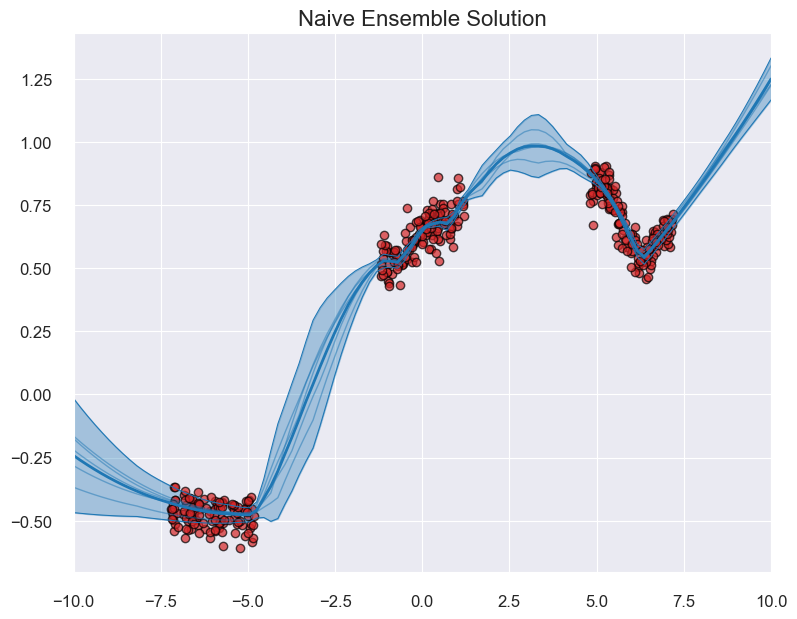

In [73]:
# Plot code from drbayes github
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32)).to(device)

trajectories = []
for model in NaiveEnsemble:
    out = model(inp).cpu().detach().numpy().T
    trajectories.append(out)
trajectories = np.vstack(trajectories)
plot_predictive(data, trajectories, z, title="Naive Ensemble Solution")

## Anchored Ensemble
In this version of Deep Ensemble we will try incorporate the Random MAP Samling approach as proposed in the Anchored Ensemble paper.

### Some math notation for Anchored Ensemble
$Loss_j = \dfrac{1}{N}GaussianNLL(y,\hat{y}_j) + \dfrac{1}{N}||\tau^{1/2}\cdot(\theta_j- \theta_{anc,j})||_2^2 $  
where $diag(\tau)_i = \sigma_{\epsilon}^2/\sigma_{prior_i}^2$  
and we draw $\theta_{anc} \sim \mathcal{N}(\mu_{prior}, \Sigma_{prior})$

In [43]:
# Let us initiate our hyperparameters
data_noise = 0.01
mu_prior = 0
# First layer prior variance
Sigma_prior_0 = 0.4
# Second layer prior variance
Sigma_prior_1 =  0.5

# Calculate tau
tau_0 = data_noise/Sigma_prior_0
tau_1 = data_noise/Sigma_prior_1

In [48]:
M = 10 # Number of ensemble members
n_hidden = 128 # Hidden units in NN
# Initiate models
AnchoredEnsemble = [BaseNN(input_shape=2,hidden_units=n_hidden,output_shape=1) for i in range(M)]

In [49]:
# Training Parameters
EPOCHS = 300
# Train each ensemble member
for model in AnchoredEnsemble:
    # Draw anchoring points (Randomly different for each NN)
    # Anchored theta first layer
    theta_anc_0 = np.random.normal(loc=mu_prior, scale=np.sqrt(Sigma_prior_0), size=[n_hidden,2])
    # Anchored theta last layer
    theta_anc_1 = np.random.normal(loc=mu_prior,scale=np.sqrt(Sigma_prior_1), size=[1,n_hidden])

    #Convert to torch tensors
    theta_anc_0 = torch.tensor(theta_anc_0).float().to(device)
    theta_anc_1 = torch.tensor(theta_anc_1).float().to(device)

    # Initiate Loss function and Optimizer
    loss_function = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr= 0.001)
    # Conduct training
    for epoch in range(EPOCHS):
        # Training
        train_loss = 0
        model.to(device)

        # Add a loop to loop through the training batches
        for batch, (X, y) in enumerate(dataloader):
            N = X.shape[0]
            model.train()
            # 1. Perform forward pass
            y_pred = model(X) # Make prediction

            # 2. Calculate loss per batch
            loss = loss_function(y_pred, y) # Calculate loss with MSE

            reg_term = 0
            # Calculate regularization
            reg_term += 1/N*tau_0*torch.mul(model.layer_stack[0].weight-theta_anc_0,model.layer_stack[0].weight-theta_anc_0).sum()
            reg_term += 1/N*tau_1*torch.mul(model.layer_stack[2].weight-theta_anc_1,model.layer_stack[2].weight-theta_anc_1).sum()

            #Accumlate loss
            loss += reg_term 
            
            train_loss += loss.item() 
            
            # 3. Optimizer zero grad
            optimizer.zero_grad() # Set the optimizer's gradients to zero

            # 4. Loss backward
            loss.backward()

            #5. Optimizer step
            optimizer.step()
        
        if epoch%50 == 0:
            print(f"Epoch: {epoch}\n-------")
            print("Loss:", train_loss / (batch + 1))  # Calculate and print average loss per epoch

Epoch: 0
-------
Loss: 0.6463866852796994
Epoch: 50
-------
Loss: 0.10564077015106495
Epoch: 100
-------
Loss: 0.08256368854871163
Epoch: 150
-------
Loss: 0.0681334539101674
Epoch: 200
-------
Loss: 0.05756849881548148
Epoch: 250
-------
Loss: 0.049853336066007614
Epoch: 0
-------
Loss: 0.9049100417357224
Epoch: 50
-------
Loss: 0.12066210806369781
Epoch: 100
-------
Loss: 0.09782757953955577
Epoch: 150
-------
Loss: 0.08036480786708686
Epoch: 200
-------
Loss: 0.066059454702414
Epoch: 250
-------
Loss: 0.05434405087278439
Epoch: 0
-------
Loss: 3.432107627391815
Epoch: 50
-------
Loss: 0.1327019167634157
Epoch: 100
-------
Loss: 0.11575772384038338
Epoch: 150
-------
Loss: 0.10230647027492523
Epoch: 200
-------
Loss: 0.09009438237318626
Epoch: 250
-------
Loss: 0.07938968275602047
Epoch: 0
-------
Loss: 1.4042681455612183
Epoch: 50
-------
Loss: 0.12370140449358867
Epoch: 100
-------
Loss: 0.10511152560894306
Epoch: 150
-------
Loss: 0.09162975331911674
Epoch: 200
-------
Loss: 0.080

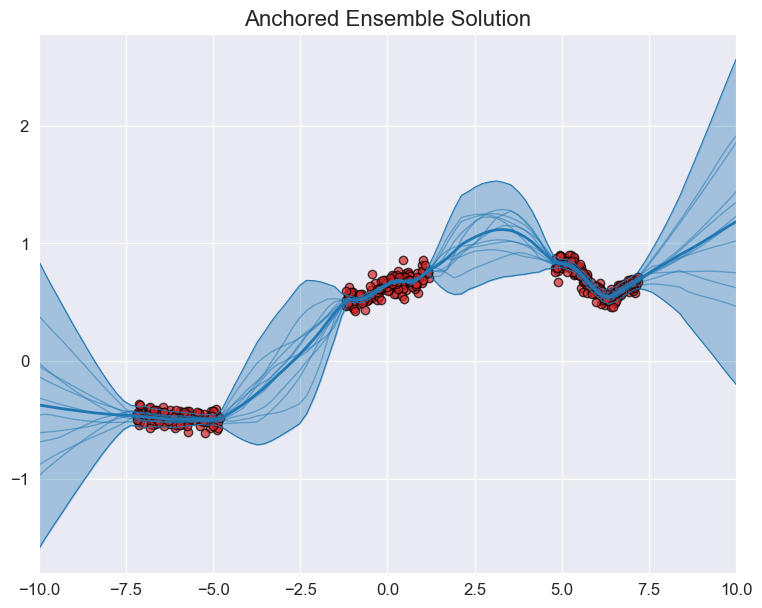

In [50]:
# Plot code from drbayes github
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32)).to(device)

trajectories = []
for model in AnchoredEnsemble:
    out = model(inp).cpu().detach().numpy().T
    trajectories.append(out)
trajectories = np.vstack(trajectories)
plot_predictive(data, trajectories, z, title="Anchored Ensemble Solution")

### Comments
This is not the appropriate Anchored Ensemble, in the above example the priors have been chosen arbitrarily. However, it seems that the authors used the weight initailization parameters as their priors for the anchors.  
However, PyTorch's Linear module uses a Kaiming Uniform initialization. We would like to instead use a Normal Distributed initailization which will allow us to use those parameters as our priors.  
Further, we would like to use a ReLU activation function, hence we will modify the torch Linear module to initalize the weights with the Kaiming Normal initialization.

## Anchored Ensemble w/ Kaiming Normal Initalization layers

In [8]:
import torch
from torch import Tensor
from torch.nn import Module
from torch.nn.parameter import Parameter
from torch.nn import init
import math
from torch.nn import functional as F
class ModifiedLinear(Module):
    """Applies a linear transformation to the incoming data: :math:`y = xA^T + b`


    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    """
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        # Prior mean
        self.mean = 0
        # Prior standard deviation, will be calculatedin reset_parameters()
        self.std = 0

        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        #init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # We use Kaiming Normal instead of Kaiming Uniform initialization
        init.kaiming_normal_(self.weight, mode='fan_out', nonlinearity='relu')
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)
        
        # We calculate the standard deviation, which is the same std deviation used to initalize the weights
        fan = init._calculate_correct_fan(self.weight, mode='fan_out')
        gain = init.calculate_gain(nonlinearity='relu')
        self.std = gain / math.sqrt(fan)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}'

## Modify the NN architecture utilizing the Kaiming Normal Initalization

In [9]:
class ModifiedBaseNN(nn.Module):
        def __init__(self,
                     input_shape:int, 
                     hidden_units: int, 
                     output_shape: int):
            super().__init__()
            self.layer_stack = nn.Sequential(
            ModifiedLinear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            ModifiedLinear(in_features=hidden_units,
                      out_features=1),
        )
        def forward(self, x):
            return self.layer_stack(x)

In [10]:
M = 5 # Number of ensemble members
n_hidden = 128 # Hidden units in NN
# Initiate models
ModifiedAnchoredEnsemble = [ModifiedBaseNN(input_shape=2,hidden_units=n_hidden,output_shape=1) for i in range(M)]

In [11]:
# The mean and std will be the same for each ensemble member, we index the first one
first_model = ModifiedAnchoredEnsemble[0]

# Initialize the prior
mu_prior = 0
# First layer prior variance
Sigma_prior_0 = first_model.layer_stack[0].std
# Second layer prior variance
Sigma_prior_1 =  first_model.layer_stack[2].std
print("The standard deviation of the first layer is:", Sigma_prior_0)
print("The standard deviation of the second layer is:", Sigma_prior_1)

# Choose hyperparameter for the data noise
data_noise = 0.01

# Calculate tau
tau_0 = data_noise/Sigma_prior_0
tau_1 = data_noise/Sigma_prior_1

The standard deviation of the first layer is: 0.125
The standard deviation of the second layer is: 1.4142135623730951


In [12]:
# Training Parameters
EPOCHS = 300
# Train each ensemble member
for model in ModifiedAnchoredEnsemble:
    # Draw anchoring points (Randomly different for each NN)
    # Anchored theta first layer
    theta_anc_0 = np.random.normal(loc=mu_prior, scale=Sigma_prior_0, size=[n_hidden,2])
    # Anchored theta last layer
    theta_anc_1 = np.random.normal(loc=mu_prior,scale=Sigma_prior_1, size=[1,n_hidden])

    #Convert to torch tensors
    theta_anc_0 = torch.tensor(theta_anc_0).float().to(device)
    theta_anc_1 = torch.tensor(theta_anc_1).float().to(device)

    # Initiate Loss function and Optimizer
    loss_function = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr= 0.001)
    # Conduct training
    for epoch in range(EPOCHS):
        # Training
        train_loss = 0
        model.to(device)

        # Add a loop to loop through the training batches
        for batch, (X, y) in enumerate(dataloader):
            N = X.shape[0]
            model.train()
            # 1. Perform forward pass
            y_pred = model(X) # Make prediction

            # 2. Calculate loss per batch
            loss = loss_function(y_pred, y) # Calculate loss with MSE

            reg_term = 0
            # Calculate regularization
            reg_term += 1/N*tau_0*torch.mul(model.layer_stack[0].weight-theta_anc_0,model.layer_stack[0].weight-theta_anc_0).sum()
            reg_term += 1/N*tau_1*torch.mul(model.layer_stack[2].weight-theta_anc_1,model.layer_stack[2].weight-theta_anc_1).sum()

            #Accumlate loss
            loss += reg_term 
            
            train_loss += loss.item() 
            
            # 3. Optimizer zero grad
            optimizer.zero_grad() # Set the optimizer's gradients to zero

            # 4. Loss backward
            loss.backward()

            #5. Optimizer step
            optimizer.step()
        
        if epoch%50 == 0:
            print(f"Epoch: {epoch}\n-------")
            print("Loss:", train_loss / (batch + 1))  # Calculate and print average loss per epoch

Epoch: 0
-------
Loss: 20.589600966526913
Epoch: 50
-------
Loss: 0.14708986419897813
Epoch: 100
-------
Loss: 0.13784070083728203
Epoch: 150
-------
Loss: 0.13100555883004114
Epoch: 200
-------
Loss: 0.12553251420076078
Epoch: 250
-------
Loss: 0.12063848571135448
Epoch: 0
-------
Loss: 25.343482677753155
Epoch: 50
-------
Loss: 0.12553816747206908
Epoch: 100
-------
Loss: 0.1077509459394675
Epoch: 150
-------
Loss: 0.10140710495985471
Epoch: 200
-------
Loss: 0.09558938902158004
Epoch: 250
-------
Loss: 0.09213230988154045
Epoch: 0
-------
Loss: 3.813696196446052
Epoch: 50
-------
Loss: 0.12960240416801894
Epoch: 100
-------
Loss: 0.11975042006144157
Epoch: 150
-------
Loss: 0.11218661012557837
Epoch: 200
-------
Loss: 0.10594542267230841
Epoch: 250
-------
Loss: 0.10038759100895661
Epoch: 0
-------
Loss: 1.5540666717749376
Epoch: 50
-------
Loss: 0.11465387390210079
Epoch: 100
-------
Loss: 0.10301707856930219
Epoch: 150
-------
Loss: 0.09647960903552863
Epoch: 200
-------
Loss: 0.0

In [17]:
print(reg_term)
print(loss)
print("W1 shape:", model.layer_stack[0].weight.shape)
print("Theta_anc_0 shape:", theta_anc_0.shape)
print("W2 shape:",model.layer_stack[2].weight.shape)
print("Theta_anc_1 shape:", theta_anc_1.shape)
print("OutFeatures x Infeatures")

tensor(0.1798, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1825, device='cuda:0', grad_fn=<AddBackward0>)
W1 shape: torch.Size([128, 2])
Theta_anc_0 shape: torch.Size([128, 2])
W2 shape: torch.Size([1, 128])
Theta_anc_1 shape: torch.Size([1, 128])
OutFeatures x Infeatures


In [73]:
ensemble_size = 10
out_features = 128
in_features = 2
test_tensor = torch.zeros(ensemble_size, out_features, in_features)
print(test_tensor.shape)

for i in range(ensemble_size):
    test_tensor[i] = torch.normal(mean=0, std = 0.1, size =(out_features, in_features))


torch.Size([10, 128, 2])


In [75]:
print(test_tensor.shape)
print(test_tensor[0])

torch.Size([10, 128, 2])
tensor([[-1.2427e-01,  1.7090e-01],
        [ 1.5474e-02,  1.3141e-01],
        [ 1.5631e-01, -1.3995e-01],
        [ 1.4604e-01,  1.3426e-01],
        [ 3.2944e-02, -1.5538e-01],
        [ 3.5398e-02,  4.5271e-02],
        [ 1.0613e-02,  2.1910e-05],
        [ 5.4716e-02, -8.8836e-02],
        [-6.1999e-02, -5.0663e-04],
        [ 7.4354e-02, -8.6339e-02],
        [-1.4187e-01,  5.0907e-02],
        [ 6.5295e-02, -9.3340e-03],
        [-6.4326e-02, -1.2045e-01],
        [-5.6837e-02,  2.6648e-02],
        [ 9.7769e-02, -6.4742e-02],
        [-1.1400e-01, -7.3773e-02],
        [ 8.9481e-02,  7.7426e-02],
        [ 3.1951e-02, -3.6632e-02],
        [ 2.9474e-02, -6.0064e-04],
        [ 9.6490e-04, -2.6856e-02],
        [ 1.3937e-01,  1.5777e-01],
        [-3.5435e-02, -1.1438e-01],
        [ 7.8135e-02,  5.5675e-02],
        [-3.0496e-04, -9.1238e-02],
        [-1.5475e-01,  1.8119e-02],
        [-2.9408e-02,  4.8701e-03],
        [-4.5463e-02,  2.0092e-01],
   

In [ ]:
theta_anc_0.shap

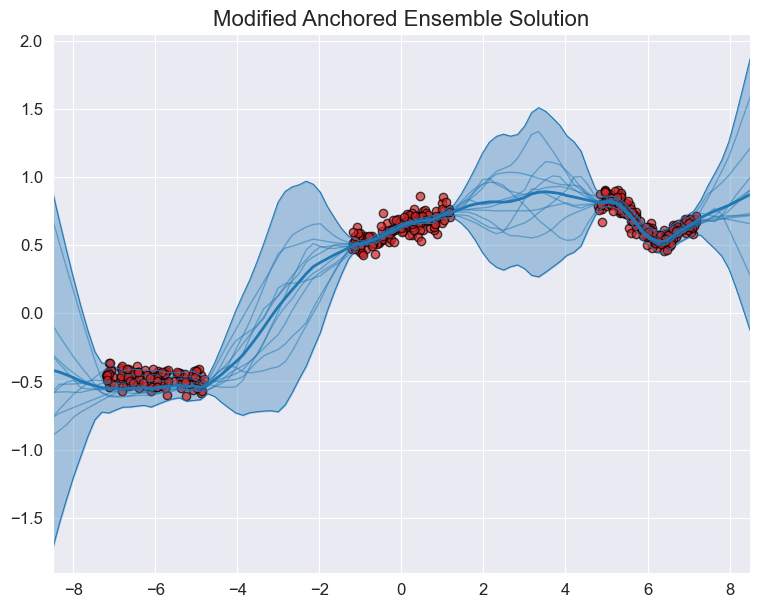

In [63]:
# Plot code from drbayes github
z = np.linspace(-8.5, 8.5, 100)
inp = torch.from_numpy(features(z).astype(np.float32)).to(device)

trajectories = []
for model in ModifiedAnchoredEnsemble:
    out = model(inp).cpu().detach().numpy().T
    trajectories.append(out)
trajectories = np.vstack(trajectories)
plot_predictive(data, trajectories, z, title="Modified Anchored Ensemble Solution")

## BatchEnsemble

In [29]:
class BaseBatchEnsemble(nn.Module):
        def __init__(self,
                     ensemble_size:int,
                     input_shape:int, 
                     hidden_units: int, 
                     output_shape: int,
                     ):
            super().__init__()
            self.layer_stack = nn.Sequential(
            BatchLinear(ensemble_size=ensemble_size,
                        in_features=input_shape,
                        out_features=hidden_units),
            nn.ReLU(),
            BatchLinear(ensemble_size=ensemble_size,
                      in_features=hidden_units,
                      out_features=1),
        )
        def forward(self, x):
            return self.layer_stack(x)

In [30]:
# Creata a Model
M = 10 # Ensemble size
h_units = 128 # Hidden units

ShallowBatchEnsemble = BaseBatchEnsemble(ensemble_size=M,input_shape=2,hidden_units=h_units,output_shape=1)

In [31]:
# Training Parameters
EPOCHS = 300
# Initiate Loss function and Optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.AdamW(ShallowBatchEnsemble.parameters(), lr= 0.02, weight_decay=0.)
ShallowBatchEnsemble.to(device)
# Conduct training
for epoch in range(EPOCHS):
    # Training
    train_loss = 0
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(dataloader):
        ShallowBatchEnsemble.train()
        # 1. Perform forward pass
        y_pred = ShallowBatchEnsemble(X.repeat(M,1)) # Make prediction

        # 2. Calculate loss per batch
        loss = loss_function(y_pred, y.repeat(M,1)) # Calculate loss with MSE

        train_loss += loss.item() # Accumalate loss

        # 3. Optimizer zero grad
        optimizer.zero_grad() # Set the optimizer's gradients to zero

        # 4. Loss backward
        loss.backward()

        #5. Optimizer step
        optimizer.step()
    if epoch%50 == 0:
        print(f"Epoch: {epoch}\n-------")
        print("Loss:", train_loss / (batch + 1))  # Calculate and print average loss per epoch
        
    

Epoch: 0
-------
Loss: 0.43560659369597066
Epoch: 50
-------
Loss: 0.0037476583025776423
Epoch: 100
-------
Loss: 0.0035073793708131863
Epoch: 150
-------
Loss: 0.0034080636866677264
Epoch: 200
-------
Loss: 0.003355072793335869
Epoch: 250
-------
Loss: 0.00324680871115281


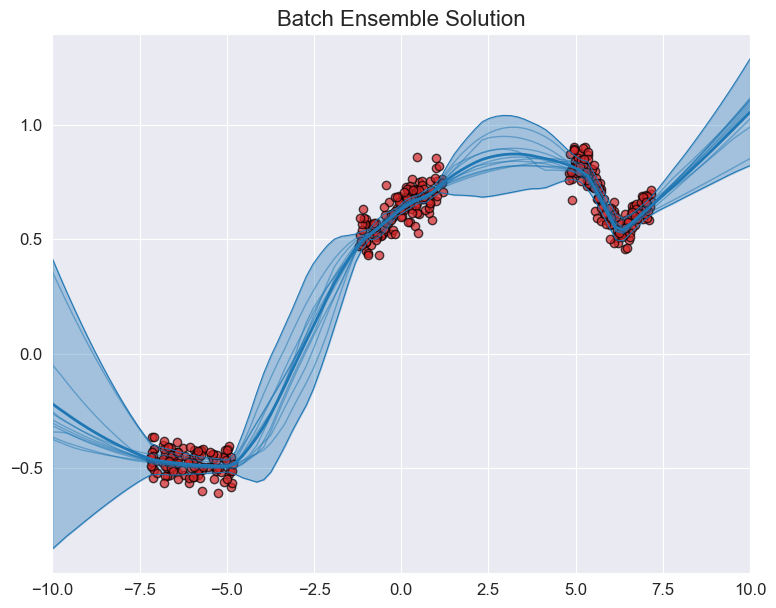

In [32]:
# Plot code from drbayes github
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32)).to(device)

trajectories = []
out = ShallowBatchEnsemble(inp.repeat(M,1)).cpu().detach().numpy().T

trajectories.append(out)
# trajeectories shape is (100*M) we need to reshape --> (M,100)
trajectories = np.vstack(trajectories).reshape(M,100)


plot_predictive(data, trajectories, z, title="Batch Ensemble Solution")

## AnchoredBatch Ensemble
Combine Anchored with Batch Ensembling

In [5]:
class AnchoredBatchEnsemble(nn.Module):
        def __init__(self,
                     ensemble_size:int,
                     input_shape:int, 
                     hidden_units: int, 
                     output_shape: int,
                     device
                     ):
            super().__init__()
            self.layer_stack = nn.Sequential(
            AnchoredBatch(ensemble_size=ensemble_size,
                        in_features=input_shape,
                        out_features=hidden_units,
                        device=device),
            nn.ReLU(),
            AnchoredBatch(ensemble_size=ensemble_size,
                          in_features=hidden_units,
                          out_features=1,
                          device=device),
        )
        def forward(self, x):
            return self.layer_stack(x)

In [6]:
# Creata a Model
M = 10 # Ensemble size
h_units = 128 # Hidden units
input_dim = 2
output_dim = 1

AnchBatchEnsemble = AnchoredBatchEnsemble(ensemble_size=M,input_shape=input_dim,hidden_units=h_units,output_shape=output_dim, device=device)

In [19]:
# Hyperparameter
data_noise = 0.001

In [20]:
# Training Parameters
EPOCHS = 300
# Initiate Loss function and Optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.AdamW(AnchBatchEnsemble.parameters(), lr= 0.02)
#AnchBatchEnsemble.to(device)
# Conduct training
for epoch in range(EPOCHS):
    # Training
    train_loss = 0
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(dataloader):
        # Number of data points in training batch
        N = X.shape[0]

        AnchBatchEnsemble.train()
        # 1. Perform forward pass
        y_pred = AnchBatchEnsemble(X.repeat(M,1)) # Make prediction

        # 2. Calculate loss per batch
        loss = loss_function(y_pred, y.repeat(M,1)) # Calculate loss with MSE
        
        # Calculate regularization
        reg_term = 0
        for layer in AnchBatchEnsemble.layer_stack.modules():
            # If layer is not activation function, then it has weights
            if hasattr(layer, 'weight'):
                reg_term += layer.get_reg_term(N,data_noise)
        # Add Regularization term to the loss
        loss += reg_term

        train_loss += loss.item() # Accumalate loss

        # 3. Optimizer zero grad
        optimizer.zero_grad() # Set the optimizer's gradients to zero

        # 4. Loss backward
        loss.backward()

        #5. Optimizer step
        optimizer.step()
    if epoch%50 == 0:
        print(f"Epoch: {epoch}\n-------")
        print("Loss:", train_loss / (batch + 1))  # Calculate and print average loss per epoch
        
    

Epoch: 0
-------
Loss: 4.845258469191881
Epoch: 50
-------
Loss: 0.04902119476061601
Epoch: 100
-------
Loss: 0.04955570972882784
Epoch: 150
-------
Loss: 0.05080723877136524
Epoch: 200
-------
Loss: 0.05022516302191294
Epoch: 250
-------
Loss: 0.05019389981260666


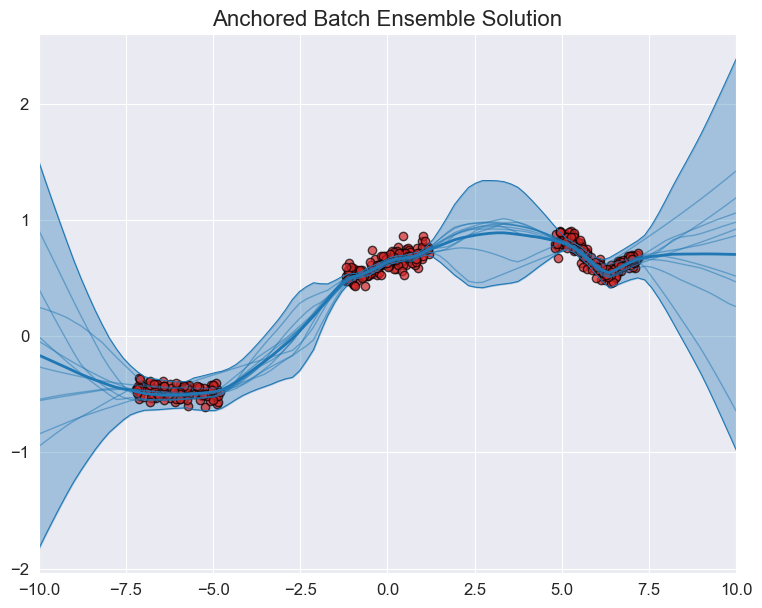

In [21]:
# Plot code from drbayes github
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32)).to(device)

trajectories = []
out = AnchBatchEnsemble(inp.repeat(M,1)).cpu().detach().numpy().T

trajectories.append(out)
# trajeectories shape is (100*M) we need to reshape --> (M,100)
trajectories = np.vstack(trajectories).reshape(M,100)


plot_predictive(data, trajectories, z, title="Anchored Batch Ensemble Solution")